# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [53]:
# Importing libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, collect_list
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType
import datetime
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns

In [2]:
# Creating a Spark session
spark = SparkSession \
    .builder \
    .appName("SparkifyProject") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#Loading the data
data = spark.read.json("mini_sparkify_event_data.json")
data.createOrReplaceTempView("data")

In [4]:
#A snapshop of the data
data.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [5]:
#Checking empty user id or session id
print("Number of empty userID:")
spark.sql("SELECT COUNT(userId) \
            FROM data \
            WHERE userId = ''").show()

print("Number of empty sessionID:")
spark.sql("SELECT COUNT(sessionId) \
            FROM data \
            WHERE sessionId = ''").show()

Number of empty userID:
+-------------+
|count(userId)|
+-------------+
|         8346|
+-------------+

Number of empty sessionID:
+----------------+
|count(sessionId)|
+----------------+
|               0|
+----------------+



In [6]:
#Dropping the records with empty user Id
data_cleaned=data.filter(data.userId!="")

In [7]:
#Checking unique number of userids
print("Number of unique userids: {}".format(data_cleaned.select("userId").dropDuplicates().count()))

Number of unique userids: 225


In [8]:
#Checking the columns available
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
#Checking unique values of some columns to figure out if they are useful
print("For 'auth' column, the unique values are:")
spark.sql("SELECT DISTINCT auth FROM data").show()

For 'auth' column, the unique values are:
+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [10]:
print("For 'itemInSession' column, the unique values are:")
spark.sql("SELECT DISTINCT itemInSession FROM data").show()

For 'itemInSession' column, the unique values are:
+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
|         1224|
|         1258|
|         1277|
|          222|
|          270|
|          293|
|          730|
|          938|
|         1127|
|         1145|
+-------------+
only showing top 20 rows



In [11]:
print("For 'level' column, the unique values are:")
spark.sql("SELECT DISTINCT level FROM data").show()

For 'level' column, the unique values are:
+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [12]:
print("For 'location' column, the unique values are:")
spark.sql("SELECT DISTINCT location FROM data").show()

For 'location' column, the unique values are:
+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [13]:
print("For 'method' column, the unique values are:")
spark.sql("SELECT DISTINCT method FROM data").show()

For 'method' column, the unique values are:
+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [14]:
print("For 'registration' column, the unique values are:")
spark.sql("SELECT DISTINCT registration FROM data").show()

For 'registration' column, the unique values are:
+-------------+
| registration|
+-------------+
|1529027541000|
|1533192032000|
|1537779419000|
|1534627466000|
|1535389443000|
|1536642109000|
|1537167593000|
|1536854322000|
|1533908361000|
|1536817381000|
|1536663902000|
|1537672236000|
|1536956945000|
|1537611935000|
|1537751138000|
|1533532298000|
|1537057938000|
|1537964483000|
|1528772084000|
|1537440271000|
+-------------+
only showing top 20 rows



In [15]:
print("For 'status' column, the unique values are:")
spark.sql("SELECT DISTINCT status FROM data").show()

For 'status' column, the unique values are:
+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [16]:
print("For 'page' column, the unique values are:")
spark.sql("SELECT DISTINCT page FROM data").show()

For 'page' column, the unique values are:
+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [17]:
print("For 'userAgent' column, the unique values are:")
spark.sql("SELECT DISTINCT userAgent FROM data").show()

For 'userAgent' column, the unique values are:
+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|                null|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 20 rows



In [18]:
#From the above exploration, we can see that the column userAgent, status, registration, method, 
#IteminSession, userAgent are not relevant for our purpose. Also since we already have userIds, we won't need name as identifiers.

#Keeping only relevant columns:

data_cleaned = data_cleaned.select('artist','auth','gender','length','level','location','sessionId','page','song','ts','userId')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
#Define churn
#I'm considering people who cancelled subscription as churned users
churned = data_cleaned.groupby("userId").agg(collect_list("page").alias("List_of_pages"))
churn_filter = udf(lambda x: "Cancellation Confirmation" in x)
churned = churned.withColumn("Churned", churn_filter(churned.List_of_pages)).drop("List_of_pages")
data_cleaned=churned.join(data_cleaned,'userId')

In [20]:
print("Number of unique users who churned: {}".format(churned.filter(churned.Churned=="true").select("userId").dropDuplicates().count()))

Number of unique users who churned: 52


Next, we'll explore the data and try to discover behaviorial differences between the users who churned and who didn't.

#### How many songs do users listen to on average between visiting our home page?

In [21]:
data_cleaned.filter(data_cleaned.Churned=="true").createOrReplaceTempView("churned_true")
is_home = spark.sql("SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home FROM churned_true \
            WHERE (page = 'NextSong') or (page = 'Home') \
            ")
is_home.createOrReplaceTempView("is_home_table")
cumulative_sum = spark.sql("SELECT *, SUM(is_home) OVER \
    (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period \
    FROM is_home_table")
cumulative_sum.createOrReplaceTempView("period_table")

print("For users who churned: ")
spark.sql("SELECT AVG(count_results) FROM \
          (SELECT COUNT(*) AS count_results FROM period_table \
GROUP BY userID, period, page HAVING page = 'NextSong') AS counts").show()




data_cleaned.filter(data_cleaned.Churned=="false").createOrReplaceTempView("churned_false")
is_home = spark.sql("SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home FROM churned_false \
            WHERE (page = 'NextSong') or (page = 'Home') \
            ")
is_home.createOrReplaceTempView("is_home_table")
cumulative_sum = spark.sql("SELECT *, SUM(is_home) OVER \
    (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period \
    FROM is_home_table")
cumulative_sum.createOrReplaceTempView("period_table")

print("For users who didn't churn: ")
spark.sql("SELECT AVG(count_results) FROM \
          (SELECT COUNT(*) AS count_results FROM period_table \
GROUP BY userID, period, page HAVING page = 'NextSong') AS counts").show()


For users who churned: 
+------------------+
|avg(count_results)|
+------------------+
| 22.67538940809969|
+------------------+

For users who didn't churn: 
+------------------+
|avg(count_results)|
+------------------+
|23.768162658070914|
+------------------+



#### How many songs do users listen to on average daily?

In [22]:
date_func=udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
data_cleaned = data_cleaned.withColumn("day", date_func(col("ts")))

In [23]:
print("For users who churned: ")
data_cleaned.filter((data_cleaned.Churned=="true")&(data_cleaned.page=="NextSong")).select("userId", "day")\
    .groupBy("userId", "day").agg(count(col('day')).alias('num_songs')).agg({'num_songs':'mean'}).show()

print("For users who didn't churn: ")
data_cleaned.filter((data_cleaned.Churned=="false")&(data_cleaned.page=="NextSong")).select("userId", "day")\
    .groupBy("userId", "day").agg(count(col('day')).alias('num_songs')).agg({'num_songs':'mean'}).show()

For users who churned: 
+-----------------+
|   avg(num_songs)|
+-----------------+
|72.93386773547094|
+-----------------+

For users who didn't churn: 
+-----------------+
|   avg(num_songs)|
+-----------------+
|74.91754591637358|
+-----------------+



#### How many songs do users listen to on an average?

In [24]:
print("For users who churned: ")
data_cleaned.filter((data_cleaned.Churned=="true")&(data_cleaned.song!='null')).groupby("userId").agg(count(col('song')).alias('num_songs')).agg({'num_songs':'mean'}).show()

print("For users who didn't churn: ")
data_cleaned.filter((data_cleaned.Churned=="false")&(data_cleaned.song!='null')).groupby("userId").agg(count(col('song')).alias('num_songs')).agg({'num_songs':'mean'}).show()

For users who churned: 
+-----------------+
|   avg(num_songs)|
+-----------------+
|699.8846153846154|
+-----------------+

For users who didn't churn: 
+------------------+
|    avg(num_songs)|
+------------------+
|1108.1734104046243|
+------------------+



#### What is the average song length for the users?

In [25]:
print("For users who churned: ")
data_cleaned.filter(data_cleaned.Churned=="true").agg({'length':'mean'}).show()
print("For users who didn't churn: ")
data_cleaned.filter(data_cleaned.Churned=="false").agg({'length':'mean'}).show()

For users who churned: 
+------------------+
|       avg(length)|
+------------------+
|248.63279564406366|
+------------------+

For users who didn't churn: 
+------------------+
|       avg(length)|
+------------------+
|249.20913538881427|
+------------------+



#### What is the average number of thumbs up for the users?

In [26]:
print("For users who churned: ")
data_cleaned.filter((data_cleaned.Churned=="true")&(data_cleaned.page=='Thumbs Up')).groupby("userId").agg(count(col('page')).alias('up')).agg({'up':'mean'}).show()
print("For users who didn't churn: ")
data_cleaned.filter((data_cleaned.Churned=="false")&(data_cleaned.page=='Thumbs Up')).groupby("userId").agg(count(col('page')).alias('up')).agg({'up':'mean'}).show()

For users who churned: 
+-------+
|avg(up)|
+-------+
|  37.18|
+-------+

For users who didn't churn: 
+-----------------+
|          avg(up)|
+-----------------+
|62.89411764705882|
+-----------------+



#### What is the average number of thumbs down for the users?

In [27]:
print("For users who churned: ")
data_cleaned.filter((data_cleaned.Churned=="true")&(data_cleaned.page=='Thumbs Down')).groupby("userId").agg(count(col('page')).alias('down')).agg({'down':'mean'}).show()
print("For users who didn't churn: ")
data_cleaned.filter((data_cleaned.Churned=="false")&(data_cleaned.page=='Thumbs Down')).groupby("userId").agg(count(col('page')).alias('down')).agg({'down':'mean'}).show()

For users who churned: 
+------------------+
|         avg(down)|
+------------------+
|10.333333333333334|
+------------------+

For users who didn't churn: 
+------------------+
|         avg(down)|
+------------------+
|13.225806451612904|
+------------------+



#### What is the gender distribution?

In [28]:
print("For users who churned: ")
data_cleaned.filter(data_cleaned.Churned=="true").dropDuplicates(['userId', 'gender']).groupby('gender').count().show()
print("For users who didn't churn: ")
data_cleaned.filter(data_cleaned.Churned=="false").dropDuplicates(['userId', 'gender']).groupby('gender').count().show()

For users who churned: 
+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+

For users who didn't churn: 
+------+-----+
|gender|count|
+------+-----+
|     F|   84|
|     M|   89|
+------+-----+



Text(0.5,1,'Distribution of gender between churned vs. not churned users')

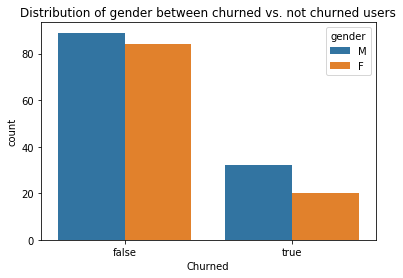

In [64]:
#Visualizing the results
df_gender = data_cleaned.dropDuplicates(["userId", "gender"]).groupby(["Churned", "gender"]).count().sort("Churned").toPandas()
sns.barplot(x='Churned', y='count', hue='gender', data=df_gender).set_title("Distribution of gender between churned vs. not churned users")

#### What is the distribution of level across the users?

Text(0.5,1,'Distribution of level across users')

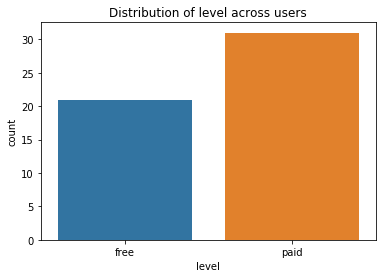

In [63]:
df_level = data_cleaned.filter(data_cleaned.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_level).set_title("Distribution of level across users")

#### What is the page use distribution between churned users and not churned users?

In [78]:
num_churned = data_cleaned.filter(data_cleaned.Churned=="true").count()
num_not_churned = data_cleaned.filter(data_cleaned.Churned=="false").count()
df1 = data_cleaned.filter(data_cleaned.Churned=="true").filter(data_cleaned.page!="NextSong").groupby(["page"]).count()
df1=df1.withColumn("churned_freq", df1["count"]/(num_churned/100)).sort("page")

df2 = data_cleaned.filter(data_cleaned.Churned=="false").filter(data_cleaned.page!="NextSong").groupby(["page"]).count()
df2 = df2.withColumn("not_churned_freq", df2["count"]/(num_not_churned/100)).sort("page")


Text(0.5,1,'Frequency distribution of churned and not churned users across numbers of hits for different pages')

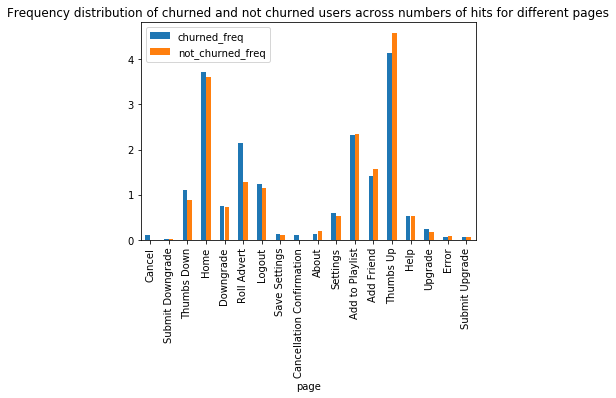

In [80]:
page_dist = df1.join(df2, "page", "outer").drop("count").fillna(0).toPandas()
page_dist.plot.bar("page").set_title("Frequency distribution of churned and not churned users across numbers of hits for different pages")

We can see, for the users who churned, the number of songs and thumbs up sre significantly lower.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

##### Now we'll engineer some features at user id level.

In [29]:
model_data=data_cleaned.select('userId').dropDuplicates(['userId',])

#Creating one-hot encoded values for the churn variable
churn= data_cleaned.select('userId', 'Churned').dropDuplicates().replace({'false': '0', 'true': '1'}, subset='Churned')
churn= churn.select('userId', churn.Churned.cast('int'))
churn.show()

+------+-------+
|userId|Churned|
+------+-------+
|100010|      0|
|200002|      0|
|   125|      1|
|   124|      0|
|    51|      1|
|     7|      0|
|    15|      0|
|    54|      1|
|   155|      0|
|100014|      1|
|   132|      0|
|   154|      0|
|   101|      1|
|    11|      0|
|   138|      0|
|300017|      0|
|100021|      1|
|    29|      1|
|    69|      0|
|   112|      0|
+------+-------+
only showing top 20 rows



####  Number of songs played

In [30]:
num_songs=data_cleaned.filter(col('song')!='null').groupby("userId").agg(count(col('song')).alias('num_songs'))
num_songs.show()

+------+---------+
|userId|num_songs|
+------+---------+
|100010|      275|
|200002|      387|
|   125|        8|
|   124|     4079|
|    51|     2111|
|     7|      150|
|    15|     1914|
|    54|     2841|
|   155|      820|
|100014|      257|
|   132|     1928|
|   154|       84|
|   101|     1797|
|    11|      647|
|   138|     2070|
|300017|     3632|
|100021|      230|
|    29|     3028|
|    69|     1125|
|   112|      215|
+------+---------+
only showing top 20 rows



#### Number of songs listened to on average per session

In [31]:
songs_per_session = data_cleaned.filter(data_cleaned.page=="NextSong").groupby("userId", "sessionId").count()
songs_per_session = songs_per_session.groupby("userId").agg(avg(songs_per_session["count"]).alias("songs_per_session"))
songs_per_session.show()

+------+------------------+
|userId| songs_per_session|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|   124|145.67857142857142|
|    51|             211.1|
|     7|21.428571428571427|
|    15|136.71428571428572|
|    54| 81.17142857142858|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|   138|             138.0|
|300017|59.540983606557376|
|100021|              46.0|
|    29| 89.05882352941177|
|    69|             125.0|
|   112| 23.88888888888889|
+------+------------------+
only showing top 20 rows



####  Number of thumbs up

In [32]:
num_up=data_cleaned.filter(data_cleaned.page=='Thumbs Up').groupby("userId").agg(count(col('page')).alias('num_up'))
num_up.show()

+------+------+
|userId|num_up|
+------+------+
|100010|    17|
|200002|    21|
|   124|   171|
|    51|   100|
|     7|     7|
|    15|    81|
|    54|   163|
|   155|    58|
|100014|    17|
|   132|    96|
|   154|    11|
|   101|    86|
|    11|    40|
|   138|    95|
|300017|   303|
|100021|    11|
|    29|   154|
|    69|    72|
|   112|     9|
|    42|   166|
+------+------+
only showing top 20 rows



####  Number of thumbs down

In [33]:
num_down=data_cleaned.filter(data_cleaned.page=='Thumbs Down').groupby("userId").agg(count(col('page')).alias('num_down'))
num_down.show()

+------+--------+
|userId|num_down|
+------+--------+
|100010|       5|
|200002|       6|
|   124|      41|
|    51|      21|
|     7|       1|
|    15|      14|
|    54|      29|
|   155|       3|
|100014|       3|
|   132|      17|
|   101|      16|
|    11|       9|
|   138|      24|
|300017|      28|
|100021|       5|
|    29|      22|
|    69|       9|
|   112|       3|
|    42|      25|
|    73|       7|
+------+--------+
only showing top 20 rows



#### Whether an user has downgraded or has visited the downgraded page

In [34]:
downgrade = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
visit_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())

In [35]:
num_downgrade = data_cleaned.withColumn("downgrade", downgrade("page"))\
        .withColumn('visit_downgrade', visit_downgrade('page'))\
        .select(['userId', 'downgrade', 'visit_downgrade'])\
        .groupBy('userId').sum()\
        .withColumnRenamed('sum(downgrade)', 'sum_downgrade')\
        .withColumnRenamed('sum(visit_downgrade)', 'sum_visit_downgrade')
num_downgrade.show()

+------+-------------+-------------------+
|userId|sum_downgrade|sum_visit_downgrade|
+------+-------------+-------------------+
|100010|            0|                  0|
|200002|            0|                  5|
|   125|            0|                  0|
|   124|            0|                 41|
|    51|            0|                 23|
|     7|            0|                  0|
|    15|            0|                 28|
|    54|            1|                 39|
|   155|            0|                 12|
|100014|            0|                  3|
|   132|            0|                 19|
|   154|            0|                  0|
|   101|            0|                 22|
|    11|            1|                  5|
|   138|            0|                 21|
|300017|            0|                 25|
|100021|            0|                  0|
|    29|            0|                 18|
|    69|            0|                  9|
|   112|            0|                  0|
+------+---

#### Number of friends added by each user

In [36]:
num_friend=data_cleaned.filter(data_cleaned.page=="Add Friend").select("userId", "page").groupBy("userId").agg(count(col("page")).alias("num_days"))
num_friend.show()

+------+--------+
|userId|num_days|
+------+--------+
|100010|       4|
|200002|       4|
|   124|      74|
|    51|      28|
|     7|       1|
|    15|      31|
|    54|      33|
|   155|      11|
|100014|       6|
|   132|      41|
|   154|       3|
|   101|      29|
|    11|       6|
|   138|      41|
|300017|      63|
|100021|       7|
|    29|      47|
|    69|      12|
|   112|       7|
|    42|      52|
+------+--------+
only showing top 20 rows



#### Average number of songs played daily by a user

In [37]:
avg_num_songs=data_cleaned.filter((data_cleaned.page=="NextSong")).select("userId", "day")\
    .groupBy("userId", "day").agg(count(col("day")).alias("num_songs")).groupBy("userId").agg(avg(col("num_songs")).alias("avg_num_songs"))
avg_num_songs.show()

+------+------------------+
|userId|     avg_num_songs|
+------+------------------+
|200002|55.285714285714285|
|100010|39.285714285714285|
|   125|               8.0|
|    51| 162.3846153846154|
|   124|         127.46875|
|     7|             18.75|
|    15|100.73684210526316|
|    54|              94.7|
|   155|             102.5|
|   132| 91.80952380952381|
|100014|42.833333333333336|
|   154|              28.0|
|    11|           40.4375|
|   101|138.23076923076923|
|300017| 75.66666666666667|
|   138|121.76470588235294|
|    29|104.41379310344827|
|100021|              46.0|
|    69|             93.75|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



#### Average session duration per user

In [38]:
start = data_cleaned.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
end = data_cleaned.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')

duration = start.join(end,['userId', 'sessionId'])
duration = duration.select('userId', 'sessionId', ((duration.end-duration.start)/(1000*60*60)).alias('session_duration'))

avg_duration=duration.groupBy('userId').agg(avg('session_duration').alias('avg_session_duration')).na.fill(0)
avg_duration.show()

+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|100010|   2.574722222222223|
|200002|                4.44|
|   125| 0.49277777777777776|
|    51|  14.539277777777775|
|   124|   9.649904214559387|
|     7|  1.4606746031746032|
|    54|   5.371493993993996|
|    15|   8.804722222222223|
|   155|    9.14287037037037|
|100014|  3.0802314814814817|
|   132|   8.315850694444444|
|   154|  1.8447222222222222|
|   101|  13.626333333333331|
|    11|  2.6896180555555556|
|300017|  3.8887345679012344|
|   138|   9.403777777777778|
|    29|   6.095947712418298|
|    69|   8.778086419753087|
|100021|   3.587111111111111|
|    42|   5.492712765957448|
+------+--------------------+
only showing top 20 rows



#### Gender of the user

In [39]:
gender=data_cleaned.select('userId', 'gender').dropDuplicates().replace({'M': '1', 'F': '0'}, subset='gender')
gender= gender.select('userId', gender.gender.cast('int'))
gender.show()

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     1|
|    15|     1|
|    54|     0|
|   155|     0|
|100014|     1|
|   132|     0|
|   154|     0|
|   101|     1|
|    11|     0|
|   138|     1|
|300017|     0|
|100021|     1|
|    29|     1|
|    69|     0|
|   112|     1|
+------+------+
only showing top 20 rows



#### Level of the user

In [40]:
level=data_cleaned.select('userId', 'level').dropDuplicates().replace({'free': '0', 'paid': '1'}, subset='level')
level= level.select('userId', level.level.cast('int'))
level.show()

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
|     7|    0|
|    15|    1|
|    54|    1|
|    54|    0|
|   155|    0|
|   155|    1|
|100014|    1|
|   132|    0|
|   132|    1|
|   154|    0|
|   101|    0|
|   101|    1|
|    11|    0|
|    11|    1|
+------+-----+
only showing top 20 rows



In [41]:
#Accumulating all the features in one dataset
model_data = model_data.join(churn, on='userId')\
        .join(num_songs, on='userId')\
        .join(songs_per_session, on='userId')\
        .join(num_up, on='userId')\
        .join(num_down, on='userId')\
        .join(num_downgrade, on='userId')\
        .join(num_friend, on='userId')\
        .join(avg_num_songs, on='userId')\
        .join(avg_duration, on='userId')\
        .join(gender, on='userId')\
        .join(level, on='userId')
model_data.show()

+------+-------+---------+------------------+------+--------+-------------+-------------------+--------+------------------+--------------------+------+-----+
|userId|Churned|num_songs| songs_per_session|num_up|num_down|sum_downgrade|sum_visit_downgrade|num_days|     avg_num_songs|avg_session_duration|gender|level|
+------+-------+---------+------------------+------+--------+-------------+-------------------+--------+------------------+--------------------+------+-----+
|100010|      0|      275|39.285714285714285|    17|       5|            0|                  0|       4|39.285714285714285|   2.574722222222223|     0|    0|
|200002|      0|      387|              64.5|    21|       6|            0|                  5|       4|55.285714285714285|                4.44|     1|    0|
|200002|      0|      387|              64.5|    21|       6|            0|                  5|       4|55.285714285714285|                4.44|     1|    1|
|   124|      0|     4079|145.67857142857142|   171|

In [42]:
#feature scaling
assembler = VectorAssembler(inputCols=model_data.columns[2:], outputCol='features_vector')
model_data = assembler.transform(model_data)
scaler = StandardScaler(inputCol='features_vector', outputCol='features_scaled', withStd=True)
scaler = scaler.fit(model_data)
model_data = scaler.transform(model_data)

model_data.show()

+------+-------+---------+------------------+------+--------+-------------+-------------------+--------+------------------+--------------------+------+-----+--------------------+--------------------+
|userId|Churned|num_songs| songs_per_session|num_up|num_down|sum_downgrade|sum_visit_downgrade|num_days|     avg_num_songs|avg_session_duration|gender|level|     features_vector|     features_scaled|
+------+-------+---------+------------------+------+--------+-------------+-------------------+--------+------------------+--------------------+------+-----+--------------------+--------------------+
|100010|      0|      275|39.285714285714285|    17|       5|            0|                  0|       4|39.285714285714285|   2.574722222222223|     0|    0|[275.0,39.2857142...|[0.24104208590807...|
|200002|      0|      387|              64.5|    21|       6|            0|                  5|       4|55.285714285714285|                4.44|     1|    0|[387.0,64.5,21.0,...|[0.33921195362336...|


In [43]:
#Final dataset having the features and the label only
model_data = model_data.select(model_data.features_scaled.alias('features'), model_data.Churned.alias('label'))

In [44]:
model_data.show(4)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.24104208590807...|    0|
|[0.33921195362336...|    0|
|[0.33921195362336...|    0|
|[3.57531152152376...|    0|
+--------------------+-----+
only showing top 4 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [45]:
#Function to evaluate model
def evaluate(validation_data):
    true_positive = validation_data.filter((validation_data.prediction==1)& (validation_data.label == validation_data.prediction) ).count()
    true_negative = validation_data.filter((validation_data.prediction==0)& (validation_data.label == validation_data.prediction) ).count()
    false_positive = validation_data.filter((validation_data.prediction==1)& (validation_data.label != validation_data.prediction) ).count()
    false_negative = validation_data.filter((validation_data.prediction==0)& (validation_data.label != validation_data.prediction) ).count()
    accuracy = validation_data.filter(validation_data.label == validation_data.prediction).count()/validation_data.count()
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    f1_score = 2 * precision * recall / (precision + recall)
    
    print ("Acuuracy: {}".format(accuracy))
    print ("Precision: {}".format(precision))
    print ("Recall: {}".format(recall))
    print ("f1-score: {}".format(f1_score))

In [46]:
#Doing a train-test-validation split
train, remaining_data = model_data.randomSplit([0.7, 0.3], seed=42)
test, validation = remaining_data.randomSplit([0.5, 0.5], seed=42)

Now I'll train some machine learning models on the final dataset. However, it is is quite small so we wopuldn't apply any deep learning algorithms here.

#### Logistic regression

In [47]:
logistic = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

param_grid = ParamGridBuilder() \
    .addGrid(logistic.regParam, [0.1, 0.01]).build()

    #.addGrid(logistic.elasticNetParam,[0.0, 0.5]) \
    #.addGrid(logistic.aggregationDepth,[2, 4]) \
    
cross_validation = CrossValidator(estimator=logistic,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model_logistic = cross_validation.fit(train)
pred_logistic = model_logistic.transform(validation)

In [48]:
print("Performance of the logistic model on validation dataset:")
evaluate(pred_logistic.select(['label', 'prediction']))


Performance of the logistic model on validation dataset:
Acuuracy: 0.7333333333333333
Precision: 0.6666666666666666
Recall: 0.09523809523809523
f1-score: 0.16666666666666666


In [105]:
model_logistic.save("logistic.model")

#### Random forest

In [48]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees ,[20, 10]) \
    .addGrid(rf.featureSubsetStrategy ,['sqrt', 'onethird']) \
    .build()

cross_validation = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model_rf = cross_validation.fit(train)
pred_rf = model_rf.transform(validation)

In [49]:
print("Performance of the random forest model on validation dataset:")
evaluate(pred_rf.select(['label', 'prediction']))

Performance of the random forest model on validation dataset:
Acuuracy: 0.7733333333333333
Precision: 1.0
Recall: 0.19047619047619047
f1-score: 0.32


#### Decision tree classifier

In [47]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth,[3, 5, 10]) \
    .build()
cross_validation = CrossValidator(estimator=dt,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model_dt = cross_validation.fit(train)
pred_dt = model_dt.transform(validation)

In [49]:
print("Performance of the decision tree model on validation dataset:")
evaluate(pred_dt.select(['label', 'prediction']))

Performance of the decision tree model on validation dataset:
Acuuracy: 0.8266666666666667
Precision: 0.7857142857142857
Recall: 0.5238095238095238
f1-score: 0.6285714285714286


#### Gradient boosting classifier

In [47]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label')
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[3, 5, 10]) \
    .build()
cross_validation = CrossValidator(estimator=gbt,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model_gbt = cross_validation.fit(train)
pred_gbt = model_gbt.transform(validation)

In [49]:
print("Performance of the gradient boosting model on validation dataset:")
evaluate(pred_gbt.select(['label', 'prediction']))

Performance of the random gradient boosting model on validation dataset:
Acuuracy: 0.8
Precision: 0.6875
Recall: 0.5238095238095238
f1-score: 0.5945945945945946


Among all the models we find the decision tree classifier to be performing the best. So, we'll apply it to the test data.

In [51]:
pred_test= model_dt.transform(test)
print("Performance of the decision tree model on test dataset:")
evaluate(pred_test.select(['label', 'prediction']))

Performance of the decision tree model on test dataset:
Acuuracy: 0.9310344827586207
Precision: 1.0
Recall: 0.7142857142857143
f1-score: 0.8333333333333333


The model has a f1-score of 0.83 which is quite good considering the small dataset.

## Conclusion and possible improvements

We are able to predict from the test set which customers are more likely to churn with 93% accuracy. As the dataset is imbalanced, we should evaluate the performance based opn f-score, and that is 0.83 for the test dataset. However, this dataset is quite small in size, and I hope the results will further improve if we try training it on the full dataset with deep learning algorithms on clusters, which is the optional part of this project that I'm going to skip. Also, for the existing models, we can try to tune more hyperparameters and improve the f1-score (I have tried to do this, but the kernel kept dying, so had to go with fewer number of hyperparameters to tune.)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.